In [1]:
from parseHtrace import Parse, hash_tree, clean_nodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## 调用关系解析

In [40]:
wordcount = Parse('wordcount.out')
wordcount.build_tree()


0it [00:00, ?it/s]
35it [00:00, 1557.70it/s]
100%|██████████| 141/141 [00:00<00:00, 54733.63it/s]

## 全采样信息 - wordcount

#### 根节点个数

In [41]:
rootName = [wordcount.nodes[h]['name'] for h in wordcount.call]
se = pd.Series(rootName)
root_info = se.value_counts()
index = [i for i in root_info.index]
data = [i for i in root_info]
root_info.to_frame()

,0
DFSOutputStream#write,95
getFileInfo,14
FileSystem#createFileSystem,6
setPermission,5
Globber#glob,5
DFSOutputStream#close,4
DistributedFileSystem#create,4
setReplication,2
DistributedFileSystem#delete,2
getContentSummary,2


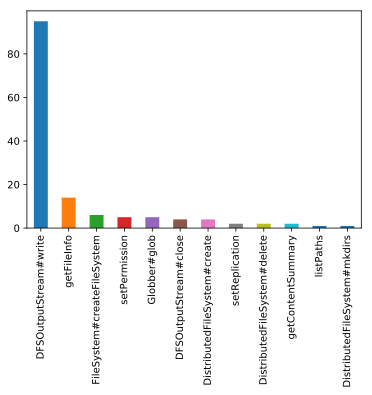

In [5]:
root_info.plot('bar')

#### 所有节点信息

In [6]:
data = wordcount.nodes.values()
func_info = clean_nodes(data)

In [7]:
df = pd.DataFrame(func_info)

In [17]:
df['name'].value_counts().to_frame()

,name
DFSOutputStream#writeChunk[lengh=512],854
DFSOutputStream#write,99
getFileInfo,17
ClientNamenodeProtocol#getFileInfo,17
DataStreamer#writeTo,14
dataStreamer,14
ClientNamenodeProtocol#setPermission,5
setPermission,5
DFSOutputStream#close,4
DFSOutputStream#flushInternal,4


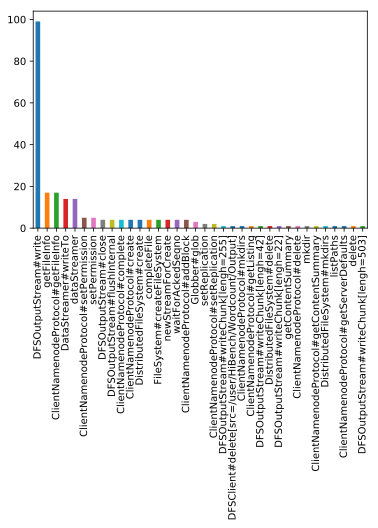

In [12]:
df['name'].value_counts().drop('DFSOutputStream#writeChunk[lengh=512]').plot(kind='bar')

### 调用树关系

In [51]:
trees = [node for node in wordcount.trees if len(node['childs'])]
hashtree = hash_tree(trees)

In [52]:
se_tree = pd.Series(hashtree)
w_tree = se_tree.value_counts().to_frame()
w_tree.to_csv("w_tree.csv")

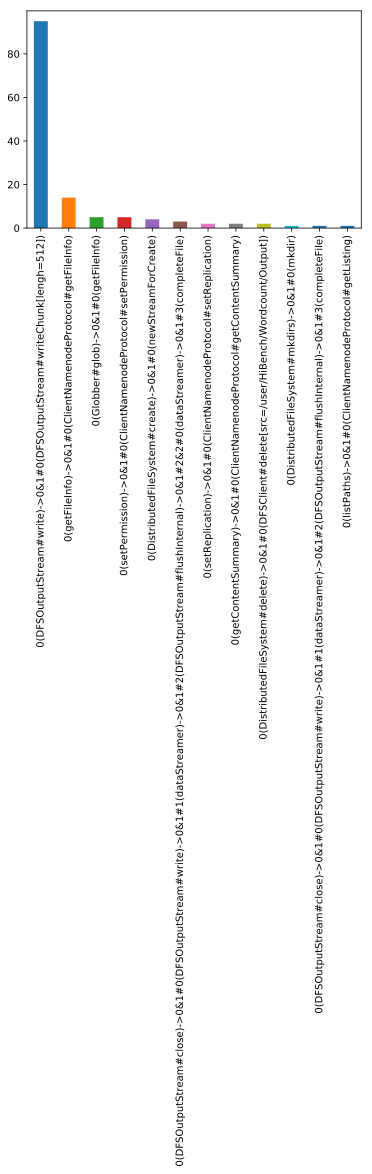

In [53]:
se_tree.value_counts().plot(kind='bar')

## 全采样信息 - terasort

In [43]:
terasort = Parse('terasort.out')
terasort.build_tree()


0it [00:00, ?it/s]
31it [00:00, 34.96it/s]

100%|██████████| 32206/32206 [00:00<00:00, 147733.18it/s]

#### 根节点个数

In [45]:
rootName = [terasort.nodes[h]['name'] for h in terasort.call]
se = pd.Series(rootName)
root_info = se.value_counts()
root_info.to_frame()

,0
DFSInputStream#byteArrayRead,32048
DFSOutputStream#write,95
getFileInfo,22
DistributedFileSystem#open,8
FileSystem#createFileSystem,6
setPermission,5
DFSOutputStream#close,5
Globber#glob,5
DistributedFileSystem#create,5
setReplication,2


#### 调用树

In [55]:
trees = [node for node in terasort.trees if len(node['childs'])]
hashtree = hash_tree(trees)

In [59]:
se_tree = pd.Series(hashtree)
t_tree = se_tree.value_counts().to_frame()
t_tree

,0
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=100]),32000
0(DFSOutputStream#write)->0&1#0(DFSOutputStream#writeChunk[lengh=512]),95
0(getFileInfo)->0&1#0(ClientNamenodeProtocol#getFileInfo),22
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=56]),8
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=20]),8
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=64]),8
0(DistributedFileSystem#open)->0&1#0(newDFSInputStream),8
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=92]),8
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=28]),8
0(DFSInputStream#byteArrayRead)->0&1#0(DFSInputStream#readWithStrategy[length=84]),8
